<a href="https://colab.research.google.com/github/Yen-Yu-Chen/wk/blob/master/Copy_of_Copy_of_%E7%AF%84%E4%BE%8B%E7%A8%8B%E5%BC%8Fv2_(%E8%AB%8B%E5%90%8C%E5%AD%B8%E8%A4%87%E8%A3%BD%E5%88%B0%E5%B0%8F%E7%B5%84%E8%B3%87%E6%96%99%E5%A4%BE%E5%BE%8C%E5%86%8D%E7%B7%A8%E8%BC%AF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 查看 GPU 資訊，建議 [Runtime/Factory reset runtime] 直到配備 K80 P100 T4，才有足夠大的記憶體。
!nvidia-smi

Thu May 28 06:12:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# 掛載 google drive 到 CoLab VM
import os
if not os.path.isdir('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Google drive is mounted !")

Google drive is mounted !


# ~ 匯入所有需要的套件模組

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# tensorflow.keras
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version =", tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers, initializers, regularizers, optimizers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K

# 匯入 tensorflow.keras.applications 模型
from tensorflow.keras.applications.xception import Xception, preprocess_input
# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.utils import shuffle
from scipy.signal import resample
from scipy import interp
from itertools import cycle, product

Tensorflow version = 2.2.0


## 路徑設定

In [ ]:
# 設定檔案路徑 (請調修改為團隊的 google drive 的資料路徑)
TRAIN_DIR = '/content/drive/Shared drives/1082_MedImg_workshop/C團隊/data/TRAIN'
VALID_DIR = '/content/drive/Shared drives/1082_MedImg_workshop/C團隊/data/VALID'
model_root = '/content/drive/Shared drives/1082_MedImg_workshop/C團隊/model'

# 1 準備資料生成器 data generator
https://keras.io/preprocessing/image/

In [ ]:
#@title 影像擴增設定
#@markdown https://keras.io/preprocessing/image/

shear_range = 0.05 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
zoom_range = 0.05 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
width_shift_range = 0.05 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
height_shift_range = 0.05 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
rotation_range = 0 #@param {type:"slider", min:0, max:90, step:5}
horizontal_flip = False #@param {type:"boolean"}
vertical_flip = False #@param {type:"boolean"}
fill_mode = 'wrap' #@param ['constant', 'nearest', 'reflect', 'wrap']

In [ ]:
#@title 建立生成器
BATCH_SIZE = 36  # 批次大小
IMAGE_SIZE = (240, 240)  # 目標影像大小

# 訓練資料生成器
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    shear_range=shear_range,
    zoom_range=zoom_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    rotation_range=rotation_range,
    horizontal_flip=horizontal_flip,
    vertical_flip=vertical_flip, 
    fill_mode=fill_mode, 
    # preprocessing_function=preprocess_input,
    ) 
train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                 target_size=IMAGE_SIZE,
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=True)
train_steps_per_epoch = np.ceil(train_generator.n / train_generator.batch_size)
print("train_steps_per_epoch =", train_steps_per_epoch)

# 驗證資料生成器 (without augmentation)
valid_datagen   = ImageDataGenerator(
    rescale=1./255, 
    # preprocessing_function=preprocess_input, 
    )
valid_generator = valid_datagen.flow_from_directory(VALID_DIR, 
                                                 target_size=IMAGE_SIZE,
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=False)
valid_steps_per_epoch = np.ceil(valid_generator.n / valid_generator.batch_size)
print("valid_steps_per_epoch =", valid_steps_per_epoch)

Found 4895 images belonging to 2 classes.
train_steps_per_epoch = 136.0
Found 16 images belonging to 2 classes.
valid_steps_per_epoch = 1.0


CLASSES: ['NORMAL', 'PNEUMONIA']
X_batch shape: (36, 240, 240, 3) 	y_batch shape: (36, 2)


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


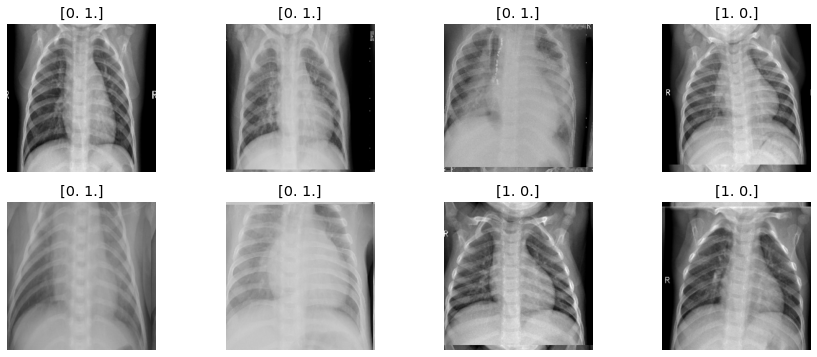

In [ ]:
#@title 視覺化檢查一些訓練影像
CLASSES = list(valid_generator.class_indices.keys())
print("CLASSES:", CLASSES)

X_batch, y_batch = train_generator.next()
print("X_batch shape:", X_batch.shape, "\ty_batch shape:", y_batch.shape)

fig=plt.figure(figsize=(15, 6))
columns = 4
rows = 2
for i in range(1, columns*rows + 1):
    img = X_batch[i-1]
    fig.add_subplot(rows, columns, i)
    plt.title(y_batch[i-1])
    plt.axis('off')
    plt.imshow(img)
plt.show()

# 2 設計模型 trandfer learning model
https://keras.io/applications/

In [ ]:
#@title 建立遷移學習模型
K.clear_session()

# 使用 tensorflow.keras.applications 預訓練模型

base_model = Xception(include_top=False, 
                      weights='imagenet', 
                      input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), 
                      pooling='avg')
base_model.trainable = False  # 凍結所有 base_model

model = Sequential()
model.add(base_model)
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(CLASSES), activation='softmax'))  # len(CLASSES)=有幾個分類

model._name = 'C_model_o902108008_0527'  # <-- 為這個模型設計命名
model.summary()

Model: "C_model_o902108008_0527"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 32)                65568     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 20,928,170
Trainable params: 66,690
Non-trainable params: 20,861,480
_________________________________________________________________


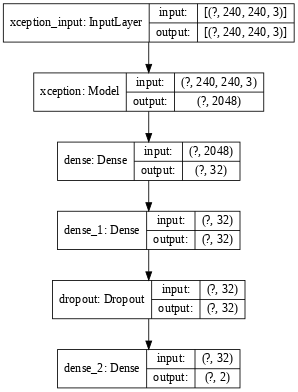

In [ ]:
#@title 畫出模型圖
# 以模型名稱建立資料夾
model_DIR = model_root + f'/{model._name}'
os.makedirs(model_DIR, exist_ok=True)

# 產生模型圖並存檔
plot_model(model, 
           to_file=model_DIR+"/model_plot.png", 
           show_shapes=True, 
           dpi=60)

# 3 訓練模型 training

In [ ]:
#@title 編譯模型
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])

In [ ]:
#@title 開始訓練
EPOCHS = 30

history = model.fit(
    train_generator, 
    steps_per_epoch=train_steps_per_epoch, 
    epochs=EPOCHS, 
    validation_data=valid_generator, 
    validation_steps=valid_steps_per_epoch)

Epoch 1/30
136/136 [==============================] - 112s 825ms/step - loss: 0.4344 - accuracy: 0.7888 - val_loss: 0.5312 - val_accuracy: 0.7321
Epoch 2/30
136/136 [==============================] - 114s 837ms/step - loss: 0.2276 - accuracy: 0.9197 - val_loss: 0.4856 - val_accuracy: 0.7911
Epoch 3/30
136/136 [==============================] - 113s 828ms/step - loss: 0.1713 - accuracy: 0.9367 - val_loss: 0.4453 - val_accuracy: 0.8198
Epoch 4/30
136/136 [==============================] - 113s 828ms/step - loss: 0.1595 - accuracy: 0.9432 - val_loss: 0.4103 - val_accuracy: 0.8373
Epoch 5/30
136/136 [==============================] - 112s 825ms/step - loss: 0.1376 - accuracy: 0.9508 - val_loss: 0.3387 - val_accuracy: 0.8740
Epoch 6/30
136/136 [==============================] - 111s 813ms/step - loss: 0.1275 - accuracy: 0.9538 - val_loss: 0.3520 - val_accuracy: 0.8692
Epoch 7/30
136/136 [==============================] - 112s 824ms/step - loss: 0.1276 - accuracy: 0.9555 - val_loss: 0.2978 -

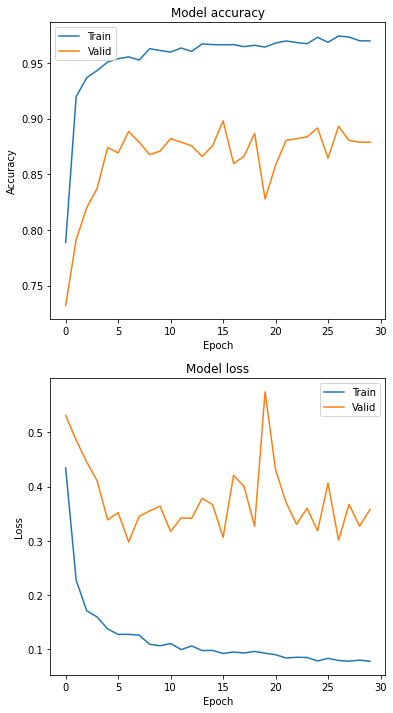

In [ ]:
#@title 畫出訓練圖
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,12))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])  # fix
ax1.plot(history.history['val_accuracy'])  # fix
ax1.set_title('Model accuracy')
ax1.set(ylabel='Accuracy', xlabel='Epoch')
ax1.legend(['Train', 'Valid'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set(ylabel='Loss', xlabel='Epoch')
ax2.legend(['Train', 'Valid'], loc='upper right')

plt.savefig('train_history.png', dpi=72)  # <-- save plot
plt.show()

In [ ]:
#@title 儲存模型
model.save(model_DIR + "/model.h5")

# 4 評估模型 evaluatiion

In [ ]:
#@title 讀取模型存檔
# 自行修改 模型檔的路徑
model = load_model("/content/drive/Shared drives/1082_MedImg_workshop/C團隊/model/C_model_o902108008_0527/model.h5")
model.trainable = False

In [ ]:
#@title 準備測試資料
# 重新初始化 valid_generator
valid_generator = valid_datagen.flow_from_directory(VALID_DIR, 
                                                 target_size=IMAGE_SIZE,
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=False)
valid_steps_per_epoch = np.ceil(valid_generator.n / valid_generator.batch_size)
print("valid_steps_per_epoch =", valid_steps_per_epoch)

# 取得正確答案 (y_test)
y_test = valid_generator.labels
y_test = to_categorical(y_test)  # as one-hot encoding

print("CLASSES:", CLASSES)
print("y_test:", y_test.shape)
print(y_test)

Found 16 images belonging to 2 classes.
valid_steps_per_epoch = 1.0
CLASSES: ['NORMAL', 'PNEUMONIA']
y_test: (16, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
#@title 開始模型預測
y_pred = model.predict(valid_generator, 
                       steps=valid_steps_per_epoch, 
                       verbose=1)
print("y_pred shape =", y_pred.shape)
np.set_printoptions(precision=4, suppress=True)
print(y_pred)

1/1 [==============================] - 0s 1ms/step
y_pred shape = (16, 2)
[[0.9704 0.0296]
 [0.9839 0.0161]
 [0.9804 0.0196]
 [0.8555 0.1445]
 [0.9779 0.0221]
 [0.6842 0.3158]
 [0.9458 0.0542]
 [0.99   0.01  ]
 [0.0004 0.9996]
 [0.0058 0.9942]
 [0.0179 0.9821]
 [0.0677 0.9323]
 [0.05   0.95  ]
 [0.0003 0.9997]
 [0.0081 0.9919]
 [0.0944 0.9056]]


<Figure size 432x288 with 0 Axes>

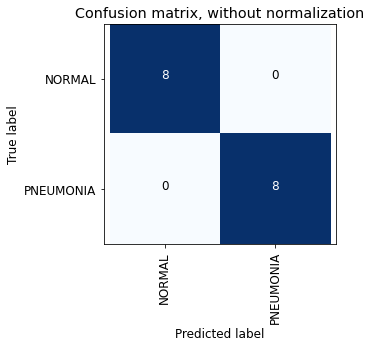

<Figure size 432x288 with 0 Axes>

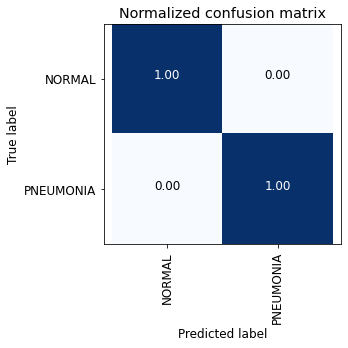

In [ ]:
#@title 畫出 混淆矩陣 confusion matrix
#@markdown https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix
class_names = CLASSES
plt.rcParams.update({'font.size': 12})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
#         print('Confusion matrix, without normalization')
        pass
#     print(cm)

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    ax.axis('equal')
    plt.xticks(tick_marks, classes, rotation='vertical')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix and savefig
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.savefig("/content/drive/Shared drives/1082_MedImg_workshop/C團隊/model/C_model_o902108008_0527" + "/confusion_matrix.png")

# Plot normalized confusion matrix and savefig
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig("/content/drive/Shared drives/1082_MedImg_workshop/C團隊/model/C_model_o902108008_0527" + "/confusion_matrix_normalized.png")

plt.show()

In [ ]:
#@title 多分類報告 classification report
#@markdown https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html?highlight=classification_report#sklearn.metrics.classification_report

report = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=CLASSES)
print(report)

# save to .txt file
with open("/content/drive/Shared drives/1082_MedImg_workshop/C團隊/model/C_model_o902108008_0527" + '/report.txt', 'w') as f:
    f.write(report)

              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00         8
   PNEUMONIA       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


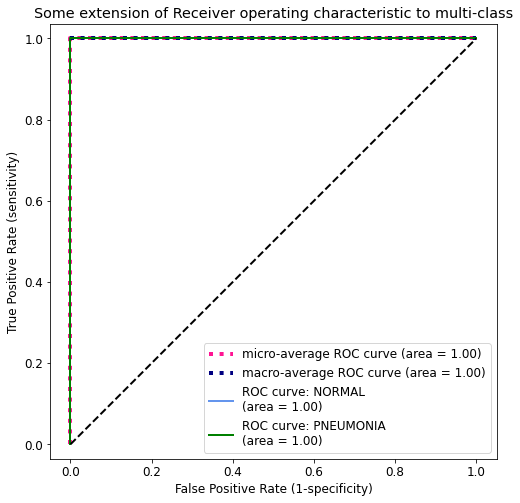

In [ ]:
#@title 畫出 ROC曲線
#@markdown https://zh.wikipedia.org/zh-tw/ROC%E6%9B%B2%E7%BA%BF
micro_avg = True  #@param {type:"boolean"}
marco_avg = True  #@param {type:"boolean"}

# 分別算出每一類別的 FPR(假陽率) TPR(真陽率) AUC(roc_curve底下的面積)
N_CLASSES = len(CLASSES)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

if micro_avg == True:
    # 計算 微觀平均曲線
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

if marco_avg == True:
    # 計算 宏觀平均曲線
    # Compute macro-average ROC curve and ROC area
    
    lw = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(N_CLASSES)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(N_CLASSES):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= N_CLASSES

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    

#### 畫出所有 ROC 曲線 ####
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

if micro_avg == True:
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

if marco_avg == True:
    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

colors = cycle(['cornflowerblue', 'green', 'darkorange', 'red'])
for i, color in zip(range(N_CLASSES), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve: {0}\n(area = {1:0.2f})'
             ''.format(CLASSES[i], roc_auc[i]))

ax.plot([0, 1], [0, 1], 'k--', lw=lw)
ax.set(xlim=(0.0, 1.0), ylim=(0.0, 1.0))
ax.axis('equal')
ax.set_xlabel('False Positive Rate (1-specificity)')
ax.set_ylabel('True Positive Rate (sensitivity)')
ax.set_title('Some extension of Receiver operating characteristic to multi-class')
ax.legend(loc="lower right")
plt.savefig("/content/drive/Shared drives/1082_MedImg_workshop/C團隊/model/C_model_o902108008_0527" + "/ROC_curve.png")
plt.show()